# Using xgboost for data exploration

Credits: https://cran.r-project.org/web/packages/xgboost/vignettes/discoverYourData.html

In [15]:
install.packages("xgboost")
install.packages("data.table")
install.packages("Matrix")

Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)
Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)
Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)


In [47]:
install.packages("Ckmeans.1d.dp")

Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)


In [48]:
require(xgboost)
require(Matrix)
require(data.table)
require(Ckmeans.1d.dp)
if (!require('vcd')) install.packages('vcd')

Loading required package: Ckmeans.1d.dp


In [19]:
data(Arthritis)
df <- data.table(Arthritis, keep.rownames = F)


In [20]:
str(df)

Classes 'data.table' and 'data.frame':	84 obs. of  5 variables:
 $ ID       : int  57 46 77 17 36 23 75 39 33 55 ...
 $ Treatment: Factor w/ 2 levels "Placebo","Treated": 2 2 2 2 2 2 2 2 2 2 ...
 $ Sex      : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 2 2 2 2 2 ...
 $ Age      : int  27 29 30 32 46 58 59 59 63 63 ...
 $ Improved : Ord.factor w/ 3 levels "None"<"Some"<..: 2 1 1 3 3 3 1 3 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [30]:
# Grouping by 10 years
df[,AgeDiscret := as.factor(round(Age/10,0))]
df[,AgeCat:= as.factor(ifelse(Age > 30, "Old", "Young"))]
print(df)


    ID Treatment    Sex Age Improved AgeDiscret AgeCat
 1: 57   Treated   Male  27     Some          3  Young
 2: 46   Treated   Male  29     None          3  Young
 3: 77   Treated   Male  30     None          3  Young
 4: 17   Treated   Male  32   Marked          3    Old
 5: 36   Treated   Male  46   Marked          5    Old
 6: 23   Treated   Male  58   Marked          6    Old
 7: 75   Treated   Male  59     None          6    Old
 8: 39   Treated   Male  59   Marked          6    Old
 9: 33   Treated   Male  63     None          6    Old
10: 55   Treated   Male  63     None          6    Old
11: 30   Treated   Male  64     None          6    Old
12:  5   Treated   Male  64     Some          6    Old
13: 63   Treated   Male  69     None          7    Old
14: 83   Treated   Male  70   Marked          7    Old
15: 66   Treated Female  23     None          2  Young
16: 40   Treated Female  32     None          3    Old
17:  6   Treated Female  37     Some          4    Old
18:  7   T

In [32]:
# Remove ID
df[,ID:=NULL]
print(df)

Warning message in `[.data.table`(df, , `:=`(ID, NULL)):
"Adding new column 'ID' then assigning NULL (deleting it)."

    Treatment    Sex Age Improved AgeDiscret AgeCat
 1:   Treated   Male  27     Some          3  Young
 2:   Treated   Male  29     None          3  Young
 3:   Treated   Male  30     None          3  Young
 4:   Treated   Male  32   Marked          3    Old
 5:   Treated   Male  46   Marked          5    Old
 6:   Treated   Male  58   Marked          6    Old
 7:   Treated   Male  59     None          6    Old
 8:   Treated   Male  59   Marked          6    Old
 9:   Treated   Male  63     None          6    Old
10:   Treated   Male  63     None          6    Old
11:   Treated   Male  64     None          6    Old
12:   Treated   Male  64     Some          6    Old
13:   Treated   Male  69     None          7    Old
14:   Treated   Male  70   Marked          7    Old
15:   Treated Female  23     None          2  Young
16:   Treated Female  32     None          3    Old
17:   Treated Female  37     Some          4    Old
18:   Treated Female  41     None          4    Old
19:   Treate

In [33]:
levels(df[,Treatment])

[1] "Placebo" "Treated"

## One-hot Encoding

In [38]:
?sparse.model.matrix 

In [39]:
# Exlcude Column Improved because it is the label column (Column to predict)
sparse_matrix <- sparse.model.matrix(Improved~.-1, data = df)
head(sparse_matrix)


   [[ suppressing 10 column names 'TreatmentPlacebo', 'TreatmentTreated', 'SexMale' ... ]]


6 x 10 sparse Matrix of class "dgCMatrix"
                      
1 . 1 1 27 1 . . . . 1
2 . 1 1 29 1 . . . . 1
3 . 1 1 30 1 . . . . 1
4 . 1 1 32 1 . . . . .
5 . 1 1 46 . . 1 . . .
6 . 1 1 58 . . . 1 . .

In [40]:
str(sparse_matrix)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:282] 41 42 43 44 45 46 47 48 49 50 ...
  ..@ p       : int [1:11] 0 43 84 109 193 203 211 226 261 275 ...
  ..@ Dim     : int [1:2] 84 10
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:84] "1" "2" "3" "4" ...
  .. ..$ : chr [1:10] "TreatmentPlacebo" "TreatmentTreated" "SexMale" "Age" ...
  ..@ x       : num [1:282] 1 1 1 1 1 1 1 1 1 1 ...
  ..@ factors : list()


In [41]:
output_vector = df[,Improved] == "Marked"

In [42]:
# Train the model
bst <- xgboost(data = sparse_matrix, label = output_vector, max_depth = 4,
               eta = 1, nthread = 2, nrounds = 10,objective = "binary:logistic")

[0]	train-error:0.202381
[1]	train-error:0.166667
[2]	train-error:0.166667
[3]	train-error:0.166667
[4]	train-error:0.154762
[5]	train-error:0.154762
[6]	train-error:0.154762
[7]	train-error:0.166667
[8]	train-error:0.166667
[9]	train-error:0.166667


In [43]:
bst

$handle
<pointer: 0xa0f6970>
attr(,"class")
[1] "xgb.Booster.handle"

$raw
   [1] 00 00 00 80 0a 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  [25] 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  [49] 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  [73] 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  [97] 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
 [121] 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 0f 00 00 00 00 00 00 00
 [145] 62 69 6e 61 72 79 3a 6c 6f 67 69 73 74 69 63 06 00 00 00 00 00 00 00 67
 [169] 62 74 72 65 65 0a 00 00 00 00 00 00 00 0a 00 00 00 00 00 00 00 00 00 00
 [193] 00 00 00 00 00 01 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
 [217] 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
 [241] 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
 [265] 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 0

In [45]:
# Measure feature importance
# Gain - Improvement in accuracy due to a feature add to a branch
importance <- xgb.importance(feature_names = colnames(sparse_matrix), model = bst)
print(importance)

            Feature        Gain       Cover  Frequence
1:              Age 0.622031651 0.672517058 0.67241379
2: TreatmentPlacebo 0.285750607 0.119166557 0.10344828
3:          SexMale 0.048744054 0.045220269 0.08620690
4:      AgeDiscret6 0.016604647 0.047846371 0.05172414
5:      AgeDiscret3 0.016373791 0.080289391 0.05172414
6:      AgeDiscret4 0.009270558 0.028588012 0.01724138
7:      AgeDiscret5 0.001224691 0.006372342 0.01724138


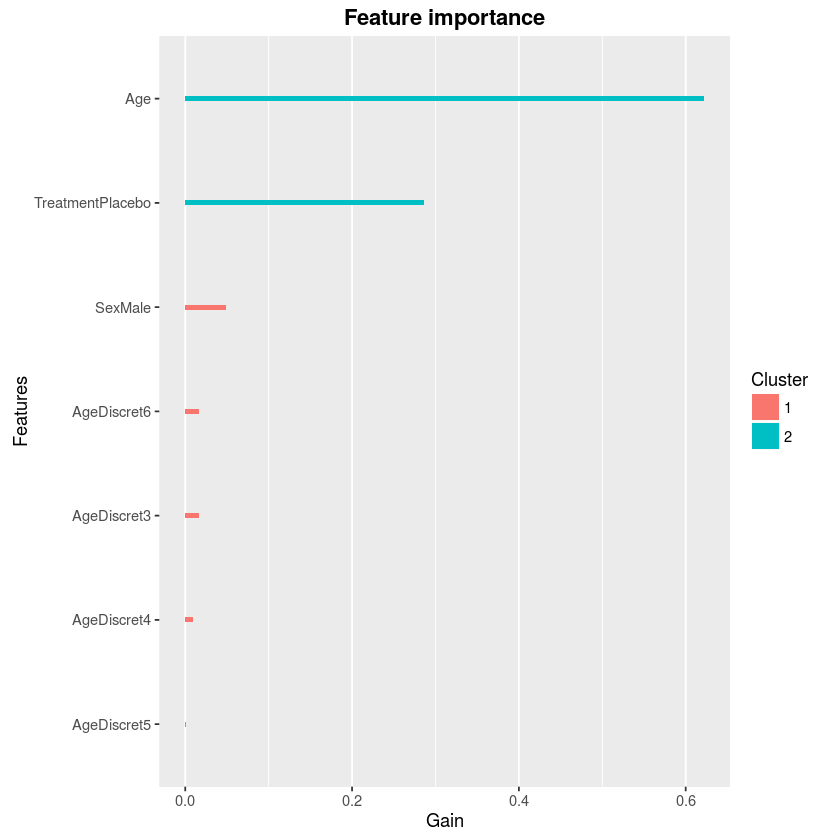

In [50]:
# Show visually the importance of each of the features
# Feature divided into 2 clusters: cluster with interesting features… and cluster with others.
xgb.plot.importance(importance_matrix = importance)